In [1]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [2]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"

In [6]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 ##
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 ##
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [7]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [8]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

100%|██████████| 2922/2922 [11:06<00:00,  4.39it/s]


In [9]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


100%|██████████| 2920/2920 [01:09<00:00, 42.27it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:09<00:00, 63.65it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 3min 3s, sys: 17 s, total: 1h 3min 20s
Wall time: 1min 29s


In [10]:
# image_helper = ImageHelper()
# image =  Image.open('../datasets/Set5/baby.png')
# image_tensor = image_helper.image_to_tensor(image)
# image_tensor = image_tensor + torch.randn(image_tensor.shape)*0.1
# image_helper.show_tensor_as_image(image_tensor)

In [14]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.33 s, sys: 236 ms, total: 1.57 s
Wall time: 1.57 s


In [12]:
# image_helper = ImageHelper()
# i = 0
# for x, y in train_dataloader:
#     i += 1
#     if i > 2:
#         break
#     image_helper.show_tensor_as_image(x[0])
#     image_helper.show_tensor_as_image(y[0])
#     print(x.shape)
#     print(y.shape)
#     break

In [13]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-3
model_betas = (0.9, 0.999)
device = torch.device('cuda:0')

# Total number of epochs
epochs = 100

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                             eta_min = 1e-6) # Minimum learning rate.

In [15]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=scheduler,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-no-noise-cuda-0.txt'
)


epoch 0
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


  0%|          | 0/1368 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1368/1368 [07:11<00:00,  3.17it/s]


Training Error: 
 Avg loss: 0.009132 



100%|██████████| 197/197 [00:24<00:00,  8.16it/s]


Validation Error: 
 Avg loss: 0.004403 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009997535269026829
Epoch: 0
Time: 457.6764030456543
Learning rate: 0.0009997535269026829
Train loss: 0.009131871288770277
Validation loss: 0.004403057166606868
Elapsed time: 457.67646622657776

epoch 1
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:10<00:00,  3.18it/s]


Training Error: 
 Avg loss: 0.004576 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004359 

Learning rate (antes): 0.0009997535269026829
Learning rate (depois): 0.0009990143508499217
Epoch: 1
Time: 456.02991580963135
Learning rate: 0.0009990143508499217
Train loss: 0.004576309071785678
Validation loss: 0.004358822817566715
Elapsed time: 456.02997946739197

epoch 2
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:09<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.004580 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004611 

Learning rate (antes): 0.0009990143508499217
Learning rate (depois): 0.0009977832013192385
Epoch: 2
Time: 455.4159691333771
Learning rate: 0.0009977832013192385
Train loss: 0.004580379638185027
Validation loss: 0.004611192489170521
Elapsed time: 455.4160325527191

epoch 3
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.004583 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 0.004362 

Learning rate (antes): 0.0009977832013192385
Learning rate (depois): 0.0009960612933065818
Epoch: 3
Time: 454.64862751960754
Learning rate: 0.0009960612933065818
Train loss: 0.00458298946631397
Validation loss: 0.004361533216522241
Elapsed time: 454.6486918926239

epoch 4
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004575 



100%|██████████| 197/197 [00:23<00:00,  8.44it/s]


Validation Error: 
 Avg loss: 0.004383 

Learning rate (antes): 0.0009960612933065818
Learning rate (depois): 0.0009938503261272714
Epoch: 4
Time: 453.85347628593445
Learning rate: 0.0009938503261272714
Train loss: 0.004575009480743718
Validation loss: 0.0043834036110952344
Elapsed time: 453.85354256629944

epoch 5
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004568 



100%|██████████| 197/197 [00:23<00:00,  8.46it/s]


Validation Error: 
 Avg loss: 0.004341 

Learning rate (antes): 0.0009938503261272714
Learning rate (depois): 0.00099115248173898
Epoch: 5
Time: 452.8066017627716
Learning rate: 0.00099115248173898
Train loss: 0.00456822802120689
Validation loss: 0.004340556875370008
Elapsed time: 452.80683183670044

epoch 6
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:05<00:00,  3.22it/s]


Training Error: 
 Avg loss: 0.004558 



100%|██████████| 197/197 [00:23<00:00,  8.48it/s]


Validation Error: 
 Avg loss: 0.004350 

Learning rate (antes): 0.00099115248173898
Learning rate (depois): 0.0009879704225884043
Epoch: 6
Time: 450.79859042167664
Learning rate: 0.0009879704225884043
Train loss: 0.004557901549517934
Validation loss: 0.004350497348347518
Elapsed time: 450.79865622520447

epoch 7
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:02<00:00,  3.24it/s]


Training Error: 
 Avg loss: 0.004619 



100%|██████████| 197/197 [00:23<00:00,  8.50it/s]


Validation Error: 
 Avg loss: 0.004385 

Learning rate (antes): 0.0009879704225884043
Learning rate (depois): 0.0009843072889837512
Epoch: 7
Time: 447.8724117279053
Learning rate: 0.0009843072889837512
Train loss: 0.004618557684201126
Validation loss: 0.0043850995979607486
Elapsed time: 447.8724772930145

epoch 8
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:59<00:00,  3.26it/s]


Training Error: 
 Avg loss: 0.004538 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004375 

Learning rate (antes): 0.0009843072889837512
Learning rate (depois): 0.000980166695995633
Epoch: 8
Time: 445.3185429573059
Learning rate: 0.000980166695995633
Train loss: 0.004538117637326778
Validation loss: 0.004374963266545727
Elapsed time: 445.3186092376709

epoch 9
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004526 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004381 

Learning rate (antes): 0.000980166695995633
Learning rate (depois): 0.0009755527298894294
Epoch: 9
Time: 444.3828012943268
Learning rate: 0.0009755527298894294
Train loss: 0.0045264212260423065
Validation loss: 0.004381137028121423
Elapsed time: 444.38286685943604

epoch 10
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004556 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004361 

Learning rate (antes): 0.0009755527298894294
Learning rate (depois): 0.0009704699440926358
Epoch: 10
Time: 443.8498477935791
Learning rate: 0.0009704699440926358
Train loss: 0.004555613591712872
Validation loss: 0.0043611895268768795
Elapsed time: 443.84992003440857

epoch 11
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004529 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004328 

Learning rate (antes): 0.0009704699440926358
Learning rate (depois): 0.0009649233547011817
Epoch: 11
Time: 443.3915615081787
Learning rate: 0.0009649233547011817
Train loss: 0.0045294806492931555
Validation loss: 0.004327772585864221
Elapsed time: 443.3916256427765

epoch 12
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004561 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004343 

Learning rate (antes): 0.0009649233547011817
Learning rate (depois): 0.0009589184355291487
Epoch: 12
Time: 443.1544072628021
Learning rate: 0.0009589184355291487
Train loss: 0.004560583520766446
Validation loss: 0.004342846626765685
Elapsed time: 443.15447187423706

epoch 13
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004521 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004321 

Learning rate (antes): 0.0009589184355291487
Learning rate (depois): 0.000952461112706777
Epoch: 13
Time: 442.993581533432
Learning rate: 0.000952461112706777
Train loss: 0.004521495135697095
Validation loss: 0.0043210297070093795
Elapsed time: 442.99364590644836

epoch 14
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004510 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004341 

Learning rate (antes): 0.000952461112706777
Learning rate (depois): 0.00094555775883209
Epoch: 14
Time: 442.8019230365753
Learning rate: 0.00094555775883209
Train loss: 0.0045096964688702045
Validation loss: 0.004340798165921009
Elapsed time: 442.801988363266

epoch 15
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004523 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004324 

Learning rate (antes): 0.00094555775883209
Learning rate (depois): 0.0009382151866819101
Epoch: 15
Time: 442.77709007263184
Learning rate: 0.0009382151866819101
Train loss: 0.004522604528271283
Validation loss: 0.004324482661095179
Elapsed time: 442.77715706825256

epoch 16
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004494 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004323 

Learning rate (antes): 0.0009382151866819101
Learning rate (depois): 0.0009304406424884702
Epoch: 16
Time: 442.9746563434601
Learning rate: 0.0009304406424884702
Train loss: 0.004494177620743581
Validation loss: 0.004322963731888171
Elapsed time: 442.97472071647644

epoch 17
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004501 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004319 

Learning rate (antes): 0.0009304406424884702
Learning rate (depois): 0.000922241798788257
Epoch: 17
Time: 442.8207788467407
Learning rate: 0.000922241798788257
Train loss: 0.004501258411644876
Validation loss: 0.004319296243274348
Elapsed time: 442.82084608078003

epoch 18
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004505 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004329 

Learning rate (antes): 0.000922241798788257
Learning rate (depois): 0.0009136267468501441
Epoch: 18
Time: 443.1361610889435
Learning rate: 0.0009136267468501441
Train loss: 0.004505357637147729
Validation loss: 0.004328625043558647
Elapsed time: 443.13622879981995

epoch 19
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004488 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004359 

Learning rate (antes): 0.0009136267468501441
Learning rate (depois): 0.0009046039886902867
Epoch: 19
Time: 443.5302939414978
Learning rate: 0.0009046039886902867
Train loss: 0.004488233797189546
Validation loss: 0.004358741248837261
Elapsed time: 443.5303599834442

epoch 20
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004515 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004335 

Learning rate (antes): 0.0009046039886902867
Learning rate (depois): 0.0008951824286816577
Epoch: 20
Time: 443.8277723789215
Learning rate: 0.0008951824286816577
Train loss: 0.004514795590167571
Validation loss: 0.004335344344174234
Elapsed time: 443.8278365135193

epoch 21
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004485 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004334 

Learning rate (antes): 0.0008951824286816577
Learning rate (depois): 0.0008853713647665071
Epoch: 21
Time: 443.7028305530548
Learning rate: 0.0008853713647665071
Train loss: 0.004484586053792039
Validation loss: 0.004334254419610736
Elapsed time: 443.7028982639313

epoch 22
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004491 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004372 

Learning rate (antes): 0.0008853713647665071
Learning rate (depois): 0.0008751804792804149
Epoch: 22
Time: 443.723769903183
Learning rate: 0.0008751804792804149
Train loss: 0.004490757072909479
Validation loss: 0.00437230618728495
Elapsed time: 443.72383737564087

epoch 23
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004479 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004326 

Learning rate (antes): 0.0008751804792804149
Learning rate (depois): 0.0008646198293969954
Epoch: 23
Time: 443.9459331035614
Learning rate: 0.0008646198293969954
Train loss: 0.004479345301852415
Validation loss: 0.0043257039201653885
Elapsed time: 443.9460005760193

epoch 24
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004486 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004332 

Learning rate (antes): 0.0008646198293969954
Learning rate (depois): 0.0008536998372026807
Epoch: 24
Time: 443.70247292518616
Learning rate: 0.0008536998372026807
Train loss: 0.004486021716644639
Validation loss: 0.0043319303177174195
Elapsed time: 443.7025372982025

epoch 25
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004485 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004342 

Learning rate (antes): 0.0008536998372026807
Learning rate (depois): 0.0008424312794113804
Epoch: 25
Time: 443.94175601005554
Learning rate: 0.0008424312794113804
Train loss: 0.004485288579071387
Validation loss: 0.004341668912048835
Elapsed time: 443.9418203830719

epoch 26
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004476 



100%|██████████| 197/197 [00:23<00:00,  8.53it/s]


Validation Error: 
 Avg loss: 0.004317 

Learning rate (antes): 0.0008424312794113804
Learning rate (depois): 0.0008308252767291644
Epoch: 26
Time: 444.08606719970703
Learning rate: 0.0008308252767291644
Train loss: 0.004475512090806266
Validation loss: 0.004317194632630379
Elapsed time: 444.0861475467682

epoch 27
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004474 



100%|██████████| 197/197 [00:23<00:00,  8.53it/s]


Validation Error: 
 Avg loss: 0.004313 

Learning rate (antes): 0.0008308252767291644
Learning rate (depois): 0.0008188932828794708
Epoch: 27
Time: 443.88365936279297
Learning rate: 0.0008188932828794708
Train loss: 0.004474315201395262
Validation loss: 0.004312624363287772
Elapsed time: 443.8837242126465

epoch 28
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004480 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004313 

Learning rate (antes): 0.0008188932828794708
Learning rate (depois): 0.0008066470732996621
Epoch: 28
Time: 444.0910928249359
Learning rate: 0.0008066470732996621
Train loss: 0.00448036555909519
Validation loss: 0.004312777398910544
Elapsed time: 444.09116077423096

epoch 29
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004482 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004313 

Learning rate (antes): 0.0008066470732996621
Learning rate (depois): 0.0007940987335200907
Epoch: 29
Time: 444.00074553489685
Learning rate: 0.0007940987335200907
Train loss: 0.0044824384121913245
Validation loss: 0.0043125224268999954
Elapsed time: 444.0008156299591

epoch 30
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004468 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004335 

Learning rate (antes): 0.0007940987335200907
Learning rate (depois): 0.0007812606472371396
Epoch: 30
Time: 443.8192090988159
Learning rate: 0.0007812606472371396
Train loss: 0.0044675041938116175
Validation loss: 0.004334857350813348
Elapsed time: 443.8192734718323

epoch 31
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004464 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004315 

Learning rate (antes): 0.0007812606472371396
Learning rate (depois): 0.0007681454840920091
Epoch: 31
Time: 443.74473547935486
Learning rate: 0.0007681454840920091
Train loss: 0.0044644556407563455
Validation loss: 0.004315065250136336
Elapsed time: 443.7448000907898

epoch 32
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004470 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004322 

Learning rate (antes): 0.0007681454840920091
Learning rate (depois): 0.0007547661871673109
Epoch: 32
Time: 443.71506094932556
Learning rate: 0.0007547661871673109
Train loss: 0.00446953844552729
Validation loss: 0.004322360395595696
Elapsed time: 443.71512508392334

epoch 33
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004468 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004319 

Learning rate (antes): 0.0007547661871673109
Learning rate (depois): 0.0007411359602138072
Epoch: 33
Time: 443.72138953208923
Learning rate: 0.0007411359602138072
Train loss: 0.004467536934599694
Validation loss: 0.004319095049233076
Elapsed time: 443.7214574813843

epoch 34
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004465 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 0.0007411359602138072
Learning rate (depois): 0.000727268254619904
Epoch: 34
Time: 443.8037931919098
Learning rate: 0.000727268254619904
Train loss: 0.0044652059230387035
Validation loss: 0.004305216284624778
Elapsed time: 443.8038601875305

epoch 35
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004464 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004306 

Learning rate (antes): 0.000727268254619904
Learning rate (depois): 0.0007131767561367542
Epoch: 35
Time: 443.9106283187866
Learning rate: 0.0007131767561367542
Train loss: 0.004464231312345735
Validation loss: 0.0043056176689945085
Elapsed time: 443.9106960296631

epoch 36
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004459 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004308 

Learning rate (antes): 0.0007131767561367542
Learning rate (depois): 0.0006988753713720732
Epoch: 36
Time: 444.0199062824249
Learning rate: 0.0006988753713720732
Train loss: 0.004459155096273532
Validation loss: 0.004308029220659324
Elapsed time: 444.0199701786041

epoch 37
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004459 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 0.0006988753713720732
Learning rate (depois): 0.000684378214065997
Epoch: 37
Time: 443.9333908557892
Learning rate: 0.000684378214065997
Train loss: 0.004459070366342982
Validation loss: 0.004305445839093081
Elapsed time: 443.93345642089844

epoch 38
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004466 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004304 

Learning rate (antes): 0.000684378214065997
Learning rate (depois): 0.0006696995911625234
Epoch: 38
Time: 443.83563208580017
Learning rate: 0.0006696995911625234
Train loss: 0.004466200311401347
Validation loss: 0.004303630456496219
Elapsed time: 443.83569955825806

epoch 39
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004458 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004307 

Learning rate (antes): 0.0006696995911625234
Learning rate (depois): 0.0006548539886902865
Epoch: 39
Time: 443.9135112762451
Learning rate: 0.0006548539886902865
Train loss: 0.004457577563310314
Validation loss: 0.004307235118065521
Elapsed time: 443.9135797023773

epoch 40
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004457 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004308 

Learning rate (antes): 0.0006548539886902865
Learning rate (depois): 0.0006398560574665953
Epoch: 40
Time: 443.9286344051361
Learning rate: 0.0006398560574665953
Train loss: 0.004456920436262126
Validation loss: 0.004307648298793903
Elapsed time: 443.92871499061584

epoch 41
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004458 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 0.0006398560574665953
Learning rate (depois): 0.0006247205986388451
Epoch: 41
Time: 443.68946290016174
Learning rate: 0.0006247205986388451
Train loss: 0.004457855655346066
Validation loss: 0.004305165287031589
Elapsed time: 443.68952775001526

epoch 42
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004455 



100%|██████████| 197/197 [00:23<00:00,  8.53it/s]


Validation Error: 
 Avg loss: 0.004308 

Learning rate (antes): 0.0006247205986388451
Learning rate (depois): 0.0006094625490775733
Epoch: 42
Time: 443.87505888938904
Learning rate: 0.0006094625490775733
Train loss: 0.0044551952285909946
Validation loss: 0.004308362881745197
Elapsed time: 443.8751266002655

epoch 43
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004456 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004314 

Learning rate (antes): 0.0006094625490775733
Learning rate (depois): 0.0005940969666355698
Epoch: 43
Time: 444.1440637111664
Learning rate: 0.0005940969666355698
Train loss: 0.004456039884724049
Validation loss: 0.004313609631067888
Elapsed time: 444.1441283226013

epoch 44
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004455 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004320 

Learning rate (antes): 0.0005940969666355698
Learning rate (depois): 0.0005786390152875956
Epoch: 44
Time: 444.0584852695465
Learning rate: 0.0005786390152875956
Train loss: 0.004454733248512746
Validation loss: 0.004319845097491678
Elapsed time: 444.05855345726013

epoch 45
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004456 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004317 

Learning rate (antes): 0.0005786390152875956
Learning rate (depois): 0.0005631039501653703
Epoch: 45
Time: 444.04106426239014
Learning rate: 0.0005631039501653703
Train loss: 0.004456190817188798
Validation loss: 0.004316764425422504
Elapsed time: 444.04113268852234

epoch 46
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004453 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004316 

Learning rate (antes): 0.0005631039501653703
Learning rate (depois): 0.0005475071025025981
Epoch: 46
Time: 443.8601486682892
Learning rate: 0.0005475071025025981
Train loss: 0.004453441653875852
Validation loss: 0.004316226047106787
Elapsed time: 443.8602137565613

epoch 47
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004453 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004309 

Learning rate (antes): 0.0005475071025025981
Learning rate (depois): 0.0005318638645048923
Epoch: 47
Time: 443.88005805015564
Learning rate: 0.0005318638645048923
Train loss: 0.004452862127340938
Validation loss: 0.00430944978955632
Elapsed time: 443.880122423172

epoch 48
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004453 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004340 

Learning rate (antes): 0.0005318638645048923
Learning rate (depois): 0.0005161896741595253
Epoch: 48
Time: 443.76875472068787
Learning rate: 0.0005161896741595253
Train loss: 0.004452517580027196
Validation loss: 0.004339553356976698
Elapsed time: 443.76882147789

epoch 49
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004451 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004304 

Learning rate (antes): 0.0005161896741595253
Learning rate (depois): 0.0005005000000000002
Epoch: 49
Time: 443.84426832199097
Learning rate: 0.0005005000000000002
Train loss: 0.004451212232213533
Validation loss: 0.004304215752254926
Elapsed time: 443.8443341255188

epoch 50
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004452 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004302 

Learning rate (antes): 0.0005005000000000002
Learning rate (depois): 0.0004848103258404751
Epoch: 50
Time: 443.6344692707062
Learning rate: 0.0004848103258404751
Train loss: 0.004451595530511637
Validation loss: 0.0043021524732762256
Elapsed time: 443.63453793525696

epoch 51
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004450 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004316 

Learning rate (antes): 0.0004848103258404751
Learning rate (depois): 0.0004691361354951082
Epoch: 51
Time: 443.5833971500397
Learning rate: 0.0004691361354951082
Train loss: 0.004449827595013439
Validation loss: 0.004315995850285922
Elapsed time: 443.5834608078003

epoch 52
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004450 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004304 

Learning rate (antes): 0.0004691361354951082
Learning rate (depois): 0.00045349289749740224
Epoch: 52
Time: 443.61334133148193
Learning rate: 0.00045349289749740224
Train loss: 0.004449566002807183
Validation loss: 0.004303715192372461
Elapsed time: 443.6134057044983

epoch 53
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004449 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004327 

Learning rate (antes): 0.00045349289749740224
Learning rate (depois): 0.0004378960498346302
Epoch: 53
Time: 443.66194248199463
Learning rate: 0.0004378960498346302
Train loss: 0.004449171108930312
Validation loss: 0.004327121515153212
Elapsed time: 443.66200947761536

epoch 54
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004449 



100%|██████████| 197/197 [00:23<00:00,  8.53it/s]


Validation Error: 
 Avg loss: 0.004307 

Learning rate (antes): 0.0004378960498346302
Learning rate (depois): 0.0004223609847124048
Epoch: 54
Time: 443.80376744270325
Learning rate: 0.0004223609847124048
Train loss: 0.004448536562199612
Validation loss: 0.004306971250033375
Elapsed time: 443.8038320541382

epoch 55
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004449 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004303 

Learning rate (antes): 0.0004223609847124048
Learning rate (depois): 0.0004069030333644307
Epoch: 55
Time: 443.7245831489563
Learning rate: 0.0004069030333644307
Train loss: 0.004448645724540533
Validation loss: 0.004302997366633966
Elapsed time: 443.7246491909027

epoch 56
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004448 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004319 

Learning rate (antes): 0.0004069030333644307
Learning rate (depois): 0.0003915374509224273
Epoch: 56
Time: 443.73389649391174
Learning rate: 0.0003915374509224273
Train loss: 0.004447678610041182
Validation loss: 0.004319192317780107
Elapsed time: 443.7339656352997

epoch 57
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004447 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004309 

Learning rate (antes): 0.0003915374509224273
Learning rate (depois): 0.0003762794013611551
Epoch: 57
Time: 443.69003033638
Learning rate: 0.0003762794013611551
Train loss: 0.004447253239177691
Validation loss: 0.004309279941965538
Elapsed time: 443.6900954246521

epoch 58
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004447 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004307 

Learning rate (antes): 0.0003762794013611551
Learning rate (depois): 0.00036114394253340513
Epoch: 58
Time: 443.65803360939026
Learning rate: 0.00036114394253340513
Train loss: 0.004446870466110117
Validation loss: 0.004306928346259756
Elapsed time: 443.6580979824066

epoch 59
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004446 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004313 

Learning rate (antes): 0.00036114394253340513
Learning rate (depois): 0.000346146011309714
Epoch: 59
Time: 443.7289102077484
Learning rate: 0.000346146011309714
Train loss: 0.004446497899806944
Validation loss: 0.004312523788427414
Elapsed time: 443.7289731502533

epoch 60
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004445 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004300 

Learning rate (antes): 0.000346146011309714
Learning rate (depois): 0.00033130040883747703
Epoch: 60
Time: 443.794260263443
Learning rate: 0.00033130040883747703
Train loss: 0.004445357662789
Validation loss: 0.004299987584699966
Elapsed time: 443.79432487487793

epoch 61
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004445 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004312 

Learning rate (antes): 0.00033130040883747703
Learning rate (depois): 0.0003166217859340036
Epoch: 61
Time: 443.73811507225037
Learning rate: 0.0003166217859340036
Train loss: 0.004445322295848269
Validation loss: 0.004312486121274985
Elapsed time: 443.7381799221039

epoch 62
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004445 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004306 

Learning rate (antes): 0.0003166217859340036
Learning rate (depois): 0.0003021246286279271
Epoch: 62
Time: 443.6985824108124
Learning rate: 0.0003021246286279271
Train loss: 0.004445048497733796
Validation loss: 0.0043059274288920245
Elapsed time: 443.6986458301544

epoch 63
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004444 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004301 

Learning rate (antes): 0.0003021246286279271
Learning rate (depois): 0.00028782324386324626
Epoch: 63
Time: 443.6048114299774
Learning rate: 0.00028782324386324626
Train loss: 0.004443856534529042
Validation loss: 0.00430086510064468
Elapsed time: 443.6048755645752

epoch 64
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004444 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 0.00028782324386324626
Learning rate (depois): 0.00027373174538009644
Epoch: 64
Time: 443.6416871547699
Learning rate: 0.00027373174538009644
Train loss: 0.00444420659029584
Validation loss: 0.004305144092942669
Elapsed time: 443.64175391197205

epoch 65
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004443 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004309 

Learning rate (antes): 0.00027373174538009644
Learning rate (depois): 0.00025986403978619317
Epoch: 65
Time: 443.5500798225403
Learning rate: 0.00025986403978619317
Train loss: 0.0044434672816042456
Validation loss: 0.0043089887042184775
Elapsed time: 443.55014657974243

epoch 66
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004444 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004315 

Learning rate (antes): 0.00025986403978619317
Learning rate (depois): 0.00024623381283268956
Epoch: 66
Time: 443.6113736629486
Learning rate: 0.00024623381283268956
Train loss: 0.0044435401570000164
Validation loss: 0.004315247671468288
Elapsed time: 443.6114571094513

epoch 67
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004443 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004302 

Learning rate (antes): 0.00024623381283268956
Learning rate (depois): 0.00023285451590799108
Epoch: 67
Time: 443.56347465515137
Learning rate: 0.00023285451590799108
Train loss: 0.004443274095568708
Validation loss: 0.004302100143407183
Elapsed time: 443.5635402202606

epoch 68
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004443 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004299 

Learning rate (antes): 0.00023285451590799108
Learning rate (depois): 0.00021973935276286074
Epoch: 68
Time: 443.5245645046234
Learning rate: 0.00021973935276286074
Train loss: 0.004442536374227258
Validation loss: 0.0042993197584557845
Elapsed time: 443.5246329307556

epoch 69
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004442 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004300 

Learning rate (antes): 0.00021973935276286074
Learning rate (depois): 0.00020690126647990976
Epoch: 69
Time: 443.50143814086914
Learning rate: 0.00020690126647990976
Train loss: 0.004442229734567588
Validation loss: 0.0042998397455144164
Elapsed time: 443.5015079975128

epoch 70
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004442 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004297 

Learning rate (antes): 0.00020690126647990976
Learning rate (depois): 0.00019435292670033822
Epoch: 70
Time: 443.462708234787
Learning rate: 0.00019435292670033822
Train loss: 0.004441697633320096
Validation loss: 0.004296918392836159
Elapsed time: 443.4627728462219

epoch 71
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:58<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004442 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004298 

Learning rate (antes): 0.00019435292670033822
Learning rate (depois): 0.0001821067171205295
Epoch: 71
Time: 443.56574296951294
Learning rate: 0.0001821067171205295
Train loss: 0.004441562456750088
Validation loss: 0.004298446230769989
Elapsed time: 443.5658085346222

epoch 72
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004441 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004298 

Learning rate (antes): 0.0001821067171205295
Learning rate (depois): 0.000170174723270836
Epoch: 72
Time: 443.5752170085907
Learning rate: 0.000170174723270836
Train loss: 0.004441412967563013
Validation loss: 0.004298120632183828
Elapsed time: 443.57528853416443

epoch 73
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004441 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004303 

Learning rate (antes): 0.000170174723270836
Learning rate (depois): 0.00015856872058862001
Epoch: 73
Time: 443.5542495250702
Learning rate: 0.00015856872058862001
Train loss: 0.004441014183814534
Validation loss: 0.004302847469792829
Elapsed time: 443.5543143749237

epoch 74
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004441 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004299 

Learning rate (antes): 0.00015856872058862001
Learning rate (depois): 0.00014730016279731957
Epoch: 74
Time: 443.369078874588
Learning rate: 0.00014730016279731957
Train loss: 0.00444090766396526
Validation loss: 0.004298553043305117
Elapsed time: 443.36914253234863

epoch 75
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004440 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004304 

Learning rate (antes): 0.00014730016279731957
Learning rate (depois): 0.00013638017060300508
Epoch: 75
Time: 443.14927530288696
Learning rate: 0.00013638017060300508
Train loss: 0.004440433964404218
Validation loss: 0.004303940367379089
Elapsed time: 443.14933943748474

epoch 76
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004441 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004299 

Learning rate (antes): 0.00013638017060300508
Learning rate (depois): 0.00012581952071958545
Epoch: 76
Time: 443.0954270362854
Learning rate: 0.00012581952071958545
Train loss: 0.004440554585314644
Validation loss: 0.004298566579984189
Elapsed time: 443.0954933166504

epoch 77
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004441 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004297 

Learning rate (antes): 0.00012581952071958545
Learning rate (depois): 0.00011562863523349334
Epoch: 77
Time: 443.3663008213043
Learning rate: 0.00011562863523349334
Train loss: 0.00444052334703309
Validation loss: 0.00429682140498597
Elapsed time: 443.3663663864136

epoch 78
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004440 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004297 

Learning rate (antes): 0.00011562863523349334
Learning rate (depois): 0.00010581757131834266
Epoch: 78
Time: 443.0763714313507
Learning rate: 0.00010581757131834266
Train loss: 0.004439921424845342
Validation loss: 0.004297409542874069
Elapsed time: 443.0764362812042

epoch 79
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004440 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004299 

Learning rate (antes): 0.00010581757131834266
Learning rate (depois): 9.639601130971382e-05
Epoch: 79
Time: 443.2110893726349
Learning rate: 9.639601130971382e-05
Train loss: 0.0044399464980505775
Validation loss: 0.004298584273340285
Elapsed time: 443.21117758750916

epoch 80
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004439 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004300 

Learning rate (antes): 9.639601130971382e-05
Learning rate (depois): 8.737325314985643e-05
Epoch: 80
Time: 443.1566722393036
Learning rate: 8.737325314985643e-05
Train loss: 0.004439486413295462
Validation loss: 0.0043001030426978275
Elapsed time: 443.15673780441284

epoch 81
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004440 



100%|██████████| 197/197 [00:23<00:00,  8.54it/s]


Validation Error: 
 Avg loss: 0.004300 

Learning rate (antes): 8.737325314985643e-05
Learning rate (depois): 7.875820121174359e-05
Epoch: 81
Time: 443.1661536693573
Learning rate: 7.875820121174359e-05
Train loss: 0.00443956178472764
Validation loss: 0.004300221825919119
Elapsed time: 443.16621947288513

epoch 82
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004440 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004297 

Learning rate (antes): 7.875820121174359e-05
Learning rate (depois): 7.05593575115301e-05
Epoch: 82
Time: 442.9460928440094
Learning rate: 7.05593575115301e-05
Train loss: 0.0044395458722508874
Validation loss: 0.004297083967039125
Elapsed time: 442.94615864753723

epoch 83
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004439 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004298 

Learning rate (antes): 7.05593575115301e-05
Learning rate (depois): 6.278481331809015e-05
Epoch: 83
Time: 442.88335943222046
Learning rate: 6.278481331809015e-05
Train loss: 0.004438756174531803
Validation loss: 0.0042976173979991355
Elapsed time: 442.88343954086304

epoch 84
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004439 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004297 

Learning rate (antes): 6.278481331809015e-05
Learning rate (depois): 5.54422411679103e-05
Epoch: 84
Time: 442.99445629119873
Learning rate: 5.54422411679103e-05
Train loss: 0.0044391076296652334
Validation loss: 0.004296941056299179
Elapsed time: 442.99452233314514

epoch 85
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004439 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 5.54422411679103e-05
Learning rate (depois): 4.853888729322334e-05
Epoch: 85
Time: 442.7614116668701
Learning rate: 4.853888729322334e-05
Train loss: 0.004438581244171766
Validation loss: 0.004296208613641976
Elapsed time: 442.7614760398865

epoch 86
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 4.853888729322334e-05
Learning rate (depois): 4.2081564470851536e-05
Epoch: 86
Time: 442.9314570426941
Learning rate: 4.2081564470851536e-05
Train loss: 0.004438213611563548
Validation loss: 0.004295947206582458
Elapsed time: 442.93152618408203

epoch 87
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004439 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 4.2081564470851536e-05
Learning rate (depois): 3.6076645298818454e-05
Epoch: 87
Time: 442.91733407974243
Learning rate: 3.6076645298818454e-05
Train loss: 0.0044385803926719775
Validation loss: 0.004296456853655843
Elapsed time: 442.917400598526

epoch 88
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:23<00:00,  8.55it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 3.6076645298818454e-05
Learning rate (depois): 3.053005590736439e-05
Epoch: 88
Time: 442.7717046737671
Learning rate: 3.053005590736439e-05
Train loss: 0.0044382391186030745
Validation loss: 0.00429562249765755
Elapsed time: 442.7717730998993

epoch 89
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 3.053005590736439e-05
Learning rate (depois): 2.5447270110570814e-05
Epoch: 89
Time: 442.7192647457123
Learning rate: 2.5447270110570814e-05
Train loss: 0.004437962108685183
Validation loss: 0.004295565853330311
Elapsed time: 442.7193293571472

epoch 90
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:56<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 2.5447270110570814e-05
Learning rate (depois): 2.0833304004366997e-05
Epoch: 90
Time: 442.4350686073303
Learning rate: 2.0833304004366997e-05
Train loss: 0.004437930761136616
Validation loss: 0.004295672957494685
Elapsed time: 442.43513679504395

epoch 91
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:56<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 2.0833304004366997e-05
Learning rate (depois): 1.6692711016248837e-05
Epoch: 91
Time: 442.27278113365173
Learning rate: 1.6692711016248837e-05
Train loss: 0.00443779666021695
Validation loss: 0.004296367337955588
Elapsed time: 442.2728474140167

epoch 92
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:56<00:00,  3.29it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004295 

Learning rate (antes): 1.6692711016248837e-05
Learning rate (depois): 1.3029577411595715e-05
Epoch: 92
Time: 441.8739731311798
Learning rate: 1.3029577411595715e-05
Train loss: 0.004437879430829977
Validation loss: 0.004295430855877546
Elapsed time: 441.8740384578705

epoch 93
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:55<00:00,  3.29it/s]


Training Error: 
 Avg loss: 0.004437 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 1.3029577411595715e-05
Learning rate (depois): 9.847518261019987e-06
Epoch: 93
Time: 440.8632905483246
Learning rate: 9.847518261019987e-06
Train loss: 0.00443749078525617
Validation loss: 0.004296155877501188
Elapsed time: 440.86335921287537

epoch 94
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004437 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 9.847518261019987e-06
Learning rate (depois): 7.14967387272874e-06
Epoch: 94
Time: 440.44790482521057
Learning rate: 7.14967387272874e-06
Train loss: 0.0044374110281660785
Validation loss: 0.004295573719342235
Elapsed time: 440.44796919822693

epoch 95
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004296 

Learning rate (antes): 7.14967387272874e-06
Learning rate (depois): 4.9387066934183575e-06
Epoch: 95
Time: 440.0036280155182
Learning rate: 4.9387066934183575e-06
Train loss: 0.004437549204983591
Validation loss: 0.004295505637061891
Elapsed time: 440.00369477272034

epoch 96
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004438 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004295 

Learning rate (antes): 4.9387066934183575e-06
Learning rate (depois): 3.2167986807615425e-06
Epoch: 96
Time: 439.5880055427551
Learning rate: 3.2167986807615425e-06
Train loss: 0.00443754870494234
Validation loss: 0.004295457753726296
Elapsed time: 439.5880720615387

epoch 97
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004437 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004295 

Learning rate (antes): 3.2167986807615425e-06
Learning rate (depois): 1.9856491500783564e-06
Epoch: 97
Time: 439.57474756240845
Learning rate: 1.9856491500783564e-06
Train loss: 0.0044373471799785845
Validation loss: 0.004295373664339201
Elapsed time: 439.57481241226196

epoch 98
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004437 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004295 

Learning rate (antes): 1.9856491500783564e-06
Learning rate (depois): 1.2464730973170658e-06
Epoch: 98
Time: 439.549768447876
Learning rate: 1.2464730973170658e-06
Train loss: 0.004437212178712352
Validation loss: 0.004295381178741395
Elapsed time: 439.54983401298523

epoch 99
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004437 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]

Validation Error: 
 Avg loss: 0.004295 

Learning rate (antes): 1.2464730973170658e-06
Learning rate (depois): 1e-06
Epoch: 99
Time: 439.50281596183777
Learning rate: 1e-06
Train loss: 0.004437308743690026
Validation loss: 0.004295406385908745
Elapsed time: 439.5028805732727
CPU times: user 12h 16min 9s, sys: 5min 44s, total: 12h 21min 54s
Wall time: 12h 20min 8s


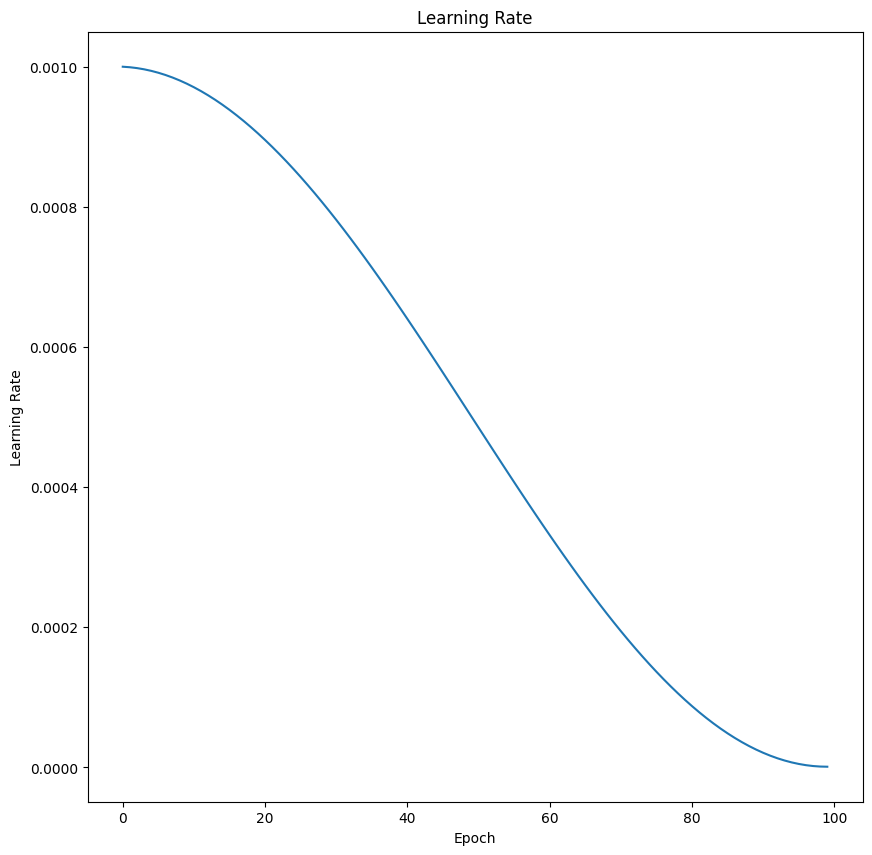

In [18]:
model_runner.plot_lr_from_df()

In [19]:
model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.csv')
model_runner.save_model_weights(model, '../results/dbpn/trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth')

In [20]:
df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.csv')
df

,epoch,time,lr,train_loss,validation_loss
0,0,457.676403,0.001000,0.009132,0.004403
1,1,456.029916,0.000999,0.004576,0.004359
2,2,455.415969,0.000998,0.004580,0.004611
3,3,454.648627,0.000996,0.004583,0.004362
4,4,453.853476,0.000994,0.004575,0.004383
...,...,...,...,...,...
95,95,440.003627,0.000005,0.004438,0.004296
96,96,439.588005,0.000003,0.004438,0.004295
97,97,439.574747,0.000002,0.004437,0.004295
98,98,439.549768,0.000001,0.004437,0.004295


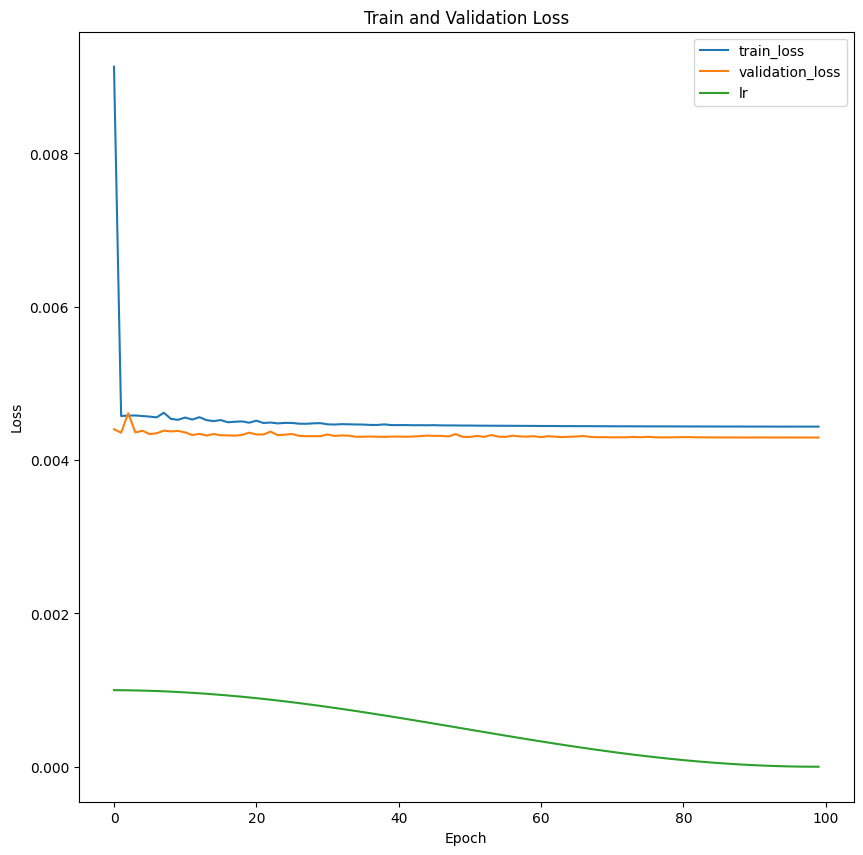

In [21]:
model_runner.plot_train_validation_loss_from_df()

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


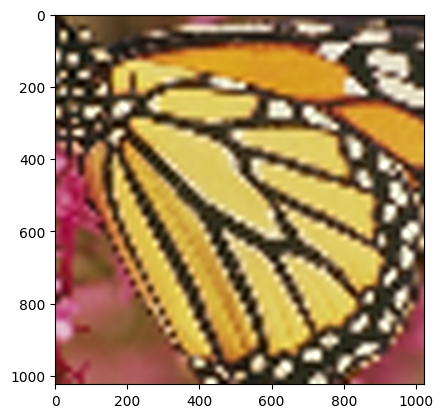

In [25]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [24]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850704,0.653421
Bicubic,23.045410,0.632868
